# bio

> Information and simple tools related to genomics information

In [ ]:
#| default_exp bio

In [ ]:
#| hide
from __future__ import annotations
from eccore.core import files_in_tree
from eccore.ipython import nb_setup
from nbdev import show_doc, nbdev_export

In [ ]:
#| hide
nb_setup()

Set autoreload mode


In [ ]:
#| hide
import json
import pandas as pd
import re
import urllib
import urllib
from itertools import chain
from pathlib import Path, PurePath
from pprint import pprint
from typing import Generator, Tuple, Union

# Information on sequence file formats

## Sequence File Formats

FASTA is a standard format to store genetic sequences.

### FASTA format

FASTA files count two lines for each sequence (see reference on [NCBI site](https://www.ncbi.nlm.nih.gov/genbank/fastaformat/)):

- line 1: the fasta definition line starting with `>` and a unique identifier, followed by optional additional information.
- line 2: the sequence line: `TATTAGGTTTTCTACCTACCCAGGAAAAGCCAACCA ...`

The format of the definition line varies from data source to data source.

Example:

```
    >MCHU - Calmodulin - Human, rabbit, bovine, rat, and chicken
    MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTEAELQDMINEVDADGNGTIDFP ....
```

## Read Files

In this project, we use read sequences from NextGen sequencing tools as well as read sequences simulated using the ART Illumina simulator tool. 

*NextGen sequencing tools* most often store read sequences in a **FASTQ** format.

*ART Illumina simulator tool* outputs both a **FASTQ** file and an alignment file (**ALN**) providing information on the original reference sequence it was simulated from. ALN files are also referred to as Clustal Alignnent format.

### FASTQ format


A FASTQ file contains one 4-line block for each read. It includes a readID, followed by both the read sequence and a quality scores, in the following format:
```text
    @readid 
    sequence_read 
    + 
    base_quality_scores 
```

Example: 
```text
    @2591237:ncbi:1-60400
    ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
    +
    CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG
```

For each base in the read sequence, a base quality score is coded by an ASCII character. They are *Q Scores* or *Phred+33* encoded, where the quality score is equal to ASCII code of the character minus 33.

>Reference information: 
>
>- [ART Illumina README file](https://gensoft.pasteur.fr/docs/ART/2016-06-05/art_illumina_README)
>- [Illumina site](https://support.illumina.com/bulletins/2016/04/fastq-files-explained.html)


**Information extraction**

The following metadata information can be parsed from **FASTQ** generated by **ART Illumina**:

FASTQ file element:

```text
    @2591237:ncbi:1-60400
    ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
    +
    CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG
```

- `readid`, e.g. `2591237:ncbi:1-60400`. 
- `read_sequence` itself, e.g. `ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG`
- `base_quality_score`, the Q Score in ASCII, e.g. `CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG`

Furthermore, the following metadata can be parsed from the first line:

    - `refseqid` of the original sequence used for the read, e.g. `2591237:nbci-1`
    - `read_nbr` of the read, e.g. `1-60400

### ALN alignment file format

An alignment file in ALN format has a `Header` and main `Body` parts. 

The header part includes the command used to generate this file and reference sequence id and length. The header `@CM` tag for command line, and `@SQ` for reference sequence.  

A `Header` always starts with `##ART` and ends with `##Header End`.

`Header` example, for ALN file generated by ART Illumina:
```ascii
    ##ART_Illumina	read_length	50
    @CM	/bin/art_illumina -i /home/vtec/projects/bio/metagentools/data/cov_data/cov_virus_sequences_ten.fa -ss HS25 -l 50 -f 100 -o /home/vtec/projects/bio/metagentools/data/cov_simreads/single_10seq_50bp/single_10seq_50bp -rs 1674660835
    @SQ	2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D	30213
    @SQ	11128:ncbi:2 [LC494191]	11128	ncbi	2 [LC494191] 11128	Bovine coronavirus      30942
    @SQ	31631:ncbi:3 [KY967361]	31631	ncbi	3 [KY967361] 31631	Human coronavirus OC43   	30661
    ##Header End
```
For each reference sequence used to build the reads, we can parse the following metadata info:
```ascii
    refseqid:       2591237:ncbi:1
    ref_seq_length: 30213
```

The `Body` part contains each read's alignments in the following format:
```ascii
    >refseqid	read_id	  aln_start_pos	   ref_seq_strand
    ref_seq_aligned
    read_seq_aligned 
```	
- `aln_start_pos` is the alignment start position of the read in the reference sequence.
- `ref_seq_aligned` is the aligned region of reference sequence, which can be from plus strand or minus strand of the reference sequence.  
- `read_seq_aligned` is the aligned sequence read, which always in the same orientation of the same read in the corresponding fastq file. 

`aln_start_pos` is always relative to the strand of reference sequence. That is, `aln_start_pos` 10 in the plus (+) strand is different from `aln_start_pos` 10 in the minus (‐) stand.  

`Body` example:
```ascii
    >2591237:ncbi:1	2591237:ncbi:1-60400	14770	+
    ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
    ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
```
```ascii
    refseqid:          2591237:ncbi:1
    readid:            2591237:ncbi:1-20100
    aln_start_pos:     23878
    ref_seq_strand:    -
    ref_seq_aligned:   ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
    read_seq_aligned:  ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
```

>Reference information: 
>
>- [ART Illumina README file](https://gensoft.pasteur.fr/docs/ART/2016-06-05/art_illumina_README)
>- [Illumina site](https://support.illumina.com/bulletins/2016/04/fastq-files-explained.html)

The quality score of a base, also known as a *Phred* or *Q score*, is an integer value representing the estimated probability of an error, i.e. the probability that the base is incorrectly sequenced. 

If $P$ is the error probability and $Q$ is the quality score for a base, then:
 
- $P = 10^{-Q/10}$
- $Q = -10 \log_{10}(P)$
 
Q scores are often represented as ASCII characters. The rule for converting an ASCII character to an integer varies. 

The two tables below convert between integer Q scores, ASCII characters and error probabilities.

**ASCII_BASE = 33** (table on top) is now almost universally used. In older systems, ASCII_BASE = 64 is also used.

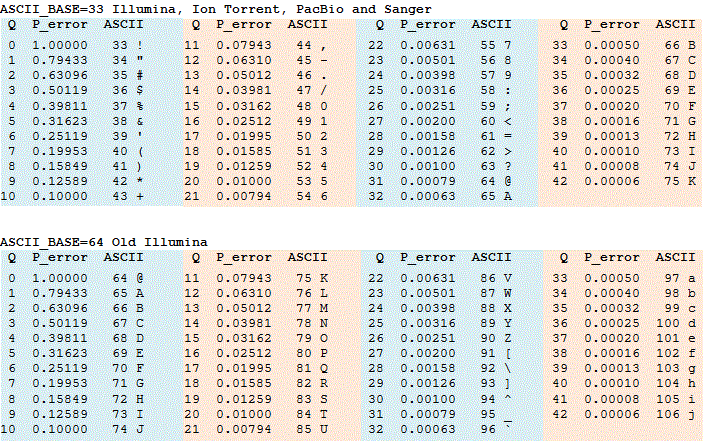

(See reference [here](http://drive5.com/usearch/manual/quality_score.html))

#### Q Score examples

- ASCII character is `K`
- ASCII code is `75`
- Q score: $Q = 75 - \small \mathrm{ASCII\_BASE} $ $= 75 - 33 = 42$
- P_error = $P = 10^{-Q/10}$, i.e. $10^{-42/10}$ = 0.00006

> **Python note**: 
>
> Decode an ASCII character with `ord(c)` and encode it with `chr(i)`

In [ ]:
ord('!'), chr(33), ord('K'), chr(75)

(33, '!', 75, 'K')

In [ ]:
#| export
def q_score2prob_error(
    char:str,             # ASCII character retrieved from Q Score or Phred value in FASTQ
    ASCII_base:int=33     # ASCII base. Mostly 33, can be 64 in old FASTQ files
):
    """Return the probability of error for a given Q score encoded as ASCII character"""
    ASCII_code = ord(char)
    Q = ASCII_code - ASCII_base
    p_error = 10**(-Q/10)
    return p_error

In [ ]:
#|echo: false
ASCII_Q_scores = ''.join([chr(i) for i in range(75, 60, -1)])
print('Selection of high Q score ASICC code, Q score values and corresponding P error:')
print(f"ASCII Q Score | Q Score | P error")
print(f"{'-'*14}|{'-'*9}|{'-'*8}")
print('\n'.join([f"{char:^14}|{ord(char)-33:^9}| {q_score2prob_error(char):6.5f} " for char in ASCII_Q_scores]))

Selection of high Q score ASICC code, Q score values and corresponding P error:
ASCII Q Score | Q Score | P error
--------------|---------|--------
      K       |   42    | 0.00006 
      J       |   41    | 0.00008 
      I       |   40    | 0.00010 
      H       |   39    | 0.00013 
      G       |   38    | 0.00016 
      F       |   37    | 0.00020 
      E       |   36    | 0.00025 
      D       |   35    | 0.00032 
      C       |   34    | 0.00040 
      B       |   33    | 0.00050 
      A       |   32    | 0.00063 
      @       |   31    | 0.00079 
      ?       |   30    | 0.00100 
      >       |   29    | 0.00126 
      =       |   28    | 0.00158 


In the case of the following FASTQ file:

```ascii
    @2591237:ncbi:1-60400
    ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
    +
    CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG
```

The following metadata information can be parsed:

- `read_id`, e.g. `2591237:ncbi:1-60400`. The following information can be parsed:
    - `ref_seq_id` of the original sequence used for the read, e.g. `2591237:nbci-1`
    - `read_nbr` of the read, e.g. `60400
- `sequence_read` itself, e.g. `ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG`
- `base_quality_score`, the Q Score in ASCII, e.g. `CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG`

This ASCII encoded Q Score can be converted into probability of error for each bp in the read:

In [ ]:
q_scores = 'CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG'
num_scores = [f"{q_score2prob_error(char):6.5f}" for char in q_scores]
print('; '.join(num_scores))
print(f"Maximum error probability: {max(num_scores)}")

0.00040; 0.00040; 0.00040; 0.00050; 0.00040; 0.00016; 0.00020; 0.00016; 0.00050; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00050; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00126; 0.00016; 0.00016; 0.00016; 0.02512; 0.00016; 0.00158; 0.03981; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016; 0.00016
Maximum error probability: 0.03981


It shows that most bp have a very low probability of error, except a few bp with probability or 2.5% and 3.9%, 

# Standard codon tables

## Standard DNA codon table

These are the basic codon tables for DNA sequences. They are used to translate DNA sequences into amino acid sequences.

**Direct DNA codon table**

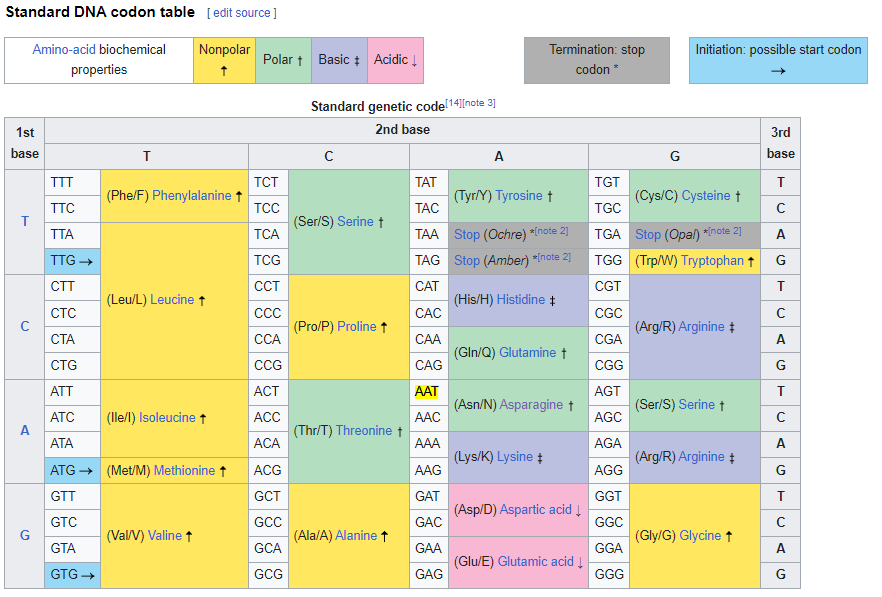

**Inverse DNA codon table**

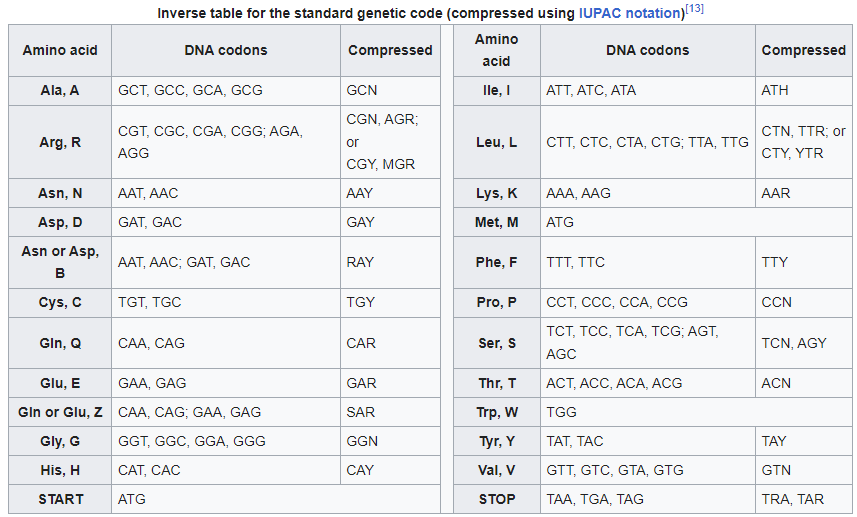

([Source](https://en.wikipedia.org/wiki/DNA_and_RNA_codon_tables))

In [ ]:
#| export
class StandardDNACodon:
    """Hold standard DNA codon reference information
    
    1. DNA codon direct table: codon -> amino acid information
    2. DNA codin inverse table amino acid code (e.g. Cys) -> list of codons
    """
    # Technical note: this is a Singleton class
    # https://medium.com/geekculture/singleton-pattern-in-python-880e3feb622e 
    
    _db = [
        ('Ala', 'A','Alanine','GCT, GCC, GCA, GCG'),
        ('Arg', 'R','Arginine','CGT, CGC, CGA, CGG, AGA, AGG'),
        ('Asn', 'N','Asparagine','AAT, AAC'),
        # ('A'sn', B','Asn or Asp, B','AAT, AAC, GAT, GAC'),
        ('Asp', 'D','Aspartic acid','GAT, GAC'),
        ('Cys', 'C','Cysteine','TGT, TGC'),
        ('Gln', 'Q','Glutamine','CAA, CAG'),
        ('Glu', 'E','Glutamic acid','GAA, GAG'),
        # ('G'ln', Z','Glu or Glu, Z','CAA, CAG, GAA, GAG '),
        ('Gly', 'G','Glycine','GGT, GGC, GGA, GGG'),
        ('His', 'H','Histidine','CAT, CAC'),
        ('Ile', 'I','Isoleucine','ATT, ATC, ATA'),
        ('Leu', 'L','Leucine','CTT, CTC, CTA, CTG, TTA, TTG'),
        ('Lys', 'K','Lysine','AAA, AAG'),
        ('Met', 'M','Methionine','ATG'),
        ('Phe', 'F','Phenylalanine','TTT, TTC'),
        ('Pro', 'P','Proline','CCT, CCC, CCA, CCG'),
        ('Ser', 'S','Serine','TCT, TCC, TCA, TCG, AGT, AGC'),
        ('Thr', 'T','Threonine','ACT, ACC, ACA, ACG'),
        ('Trp', 'W','Tryptophan','TGG'),
        ('Tyr', 'Y','Tyrosine','TAT, TAC'),
        ('Val', 'V','Valine','GTT, GTC, GTA, GTG'),
        ('START','START', 'START','ATG'),
        ('STOP','STOP', 'STOP','TAA, TGA, TAG')
    ]
    
    __instance = None  
    
    def __new__(cls):
        """Create new instance if none exists, or return the one that exists"""
        if cls.__instance is None:
            cls.__instance = super().__new__(cls)
            # create the inverse table from the db
            cls.inverse_table = {s:{'amino acid name':n, 'amino acid letter': l, 'codons': c.split(', ')} 
                             for s, l, n, c in cls._db}
        return cls.__instance

    @property
    def direct_table(cls):
        dir_table = {} 
        for k, v in cls.inverse_table.items():
            for codon in v['codons']:
                subdict = {}
                subdict['amino acid symbol'] = k
                subdict['amino acid name'] = v['amino acid name']
                subdict['amino acid letter'] = v['amino acid letter']
                dir_table[codon] = subdict
        return dir_table
    
    @property
    def amino_acid_symbols(cls):
        return [s for s, l, n, c in cls._db]
    
    @property
    def amino_acid_names(cls):
        return [n for s, l, n, c in cls._db]
    
    @property
    def amino_acid_letters(cls):
        return [l for s, l, n, c in cls._db]

In [ ]:
show_doc(StandardDNACodon)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/bio.py#L20){target="_blank" style="float:right; font-size:smaller"}

### StandardDNACodon

>      StandardDNACodon ()

*Hold standard DNA codon reference information

1. DNA codon direct table: codon -> amino acid information
2. DNA codin inverse table amino acid code (e.g. Cys) -> list of codons*

In [ ]:
codons = StandardDNACodon()

In [ ]:
key = 'Phe'
codons.inverse_table[key]

{'amino acid name': 'Phenylalanine',
 'amino acid letter': 'F',
 'codons': ['TTT', 'TTC']}

In [ ]:
key = 'TTT'
codons.direct_table[key]

{'amino acid symbol': 'Phe',
 'amino acid name': 'Phenylalanine',
 'amino acid letter': 'F'}

In [ ]:
codons.amino_acid_symbols[:5]

['Ala', 'Arg', 'Asn', 'Asp', 'Cys']

In [ ]:
codons.amino_acid_names[:5]

['Alanine', 'Arginine', 'Asparagine', 'Aspartic acid', 'Cysteine']

In [ ]:
codons.amino_acid_letters[:5]

['A', 'R', 'N', 'D', 'C']

In [ ]:
#| hide
nbdev_export()